<h1 style = "text-align: center">Collaborative Filtering Data Model</h1>

<h3 style = "text-align: center">Food.com Recipe Recommender - SOEN 471 (Big Data Analytics)</h3>

## Objective:
The objective of this notebook is to create a recommender system data model that recommend recipes based on user preferences using collaborative filtering.

In [1]:
import os
import json
import numpy as np
import pandas as pd 
import dask.array as da
import dask.dataframe as dd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# accessing directory
for dirname, _, filenames in os.walk('./clean_data'):
    for filename in filenames:
        os.path.join(dirname, filename)

## Reading files:

In [2]:
# Removing column titled "Unnamed: 0"
training = dd.read_csv("./clean_data/interactions_TRAIN.csv").drop("Unnamed: 0", axis=1)
#testing = dd.read_csv("./clean_data/interactions_TEST.csv").drop("Unnamed: 0", axis=1)
recipes = dd.read_csv("./clean_data/recipes.csv").drop("Unnamed: 0", axis=1)

## Print Training Data

In [3]:
training.head()

,user_id,recipe_id,date,rating,review
0,59801,8060,2007-12-11,5,This really is a great basic meatball recipe. ...
1,104295,38353,2005-02-08,5,Very yummy. I quartered the recipe and theref...
2,58104,162999,2007-03-05,5,OK this may be a great Canadian drink! But whe...
3,2000207498,2886,2015-05-16,5,Great recipe. I made a lot of changes though a...
4,41695,27082,2002-06-10,4,"Very easy to make and I liked it, my kids didn..."


In [4]:
recipes[recipes['recipe_id'] == 0].compute()

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,Calories,Total_fat_PDV,Sugar_PDV,Sodium_PDV,Protein_PDV,Saturated_fat_PDV,Carbohydrates_PDV


## Print Recipes Data

In [5]:
recipes.head()

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,Calories,Total_fat_PDV,Sugar_PDV,Sodium_PDV,Protein_PDV,Saturated_fat_PDV,Carbohydrates_PDV
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,352.9,1.0,337.0,23.0,3.0,0.0,28.0


## Add user rating column per recipe

In [6]:
recipes_ratings = dd.merge(recipes, training)
recipes_ratings.head(15)

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,...,Total_fat_PDV,Sugar_PDV,Sodium_PDV,Protein_PDV,Saturated_fat_PDV,Carbohydrates_PDV,user_id,date,rating,review
0,copycat of arby s chicken salad sandwich,388944,10,655996,2009-09-06,"['weeknight', '15-minutes-or-less', 'time-to-m...",10,"['1', 'combine the first six ingredients and m...",this is the actual arby's chicken salad sandwi...,"['chicken breasts', 'mayonnaise', 'celery', 'p...",...,48.0,64.0,4.0,54.0,24.0,7.0,2000264903,2015-06-12,0,Why would you say you believe Arby&#039;s used...
1,copycat of arby s chicken salad sandwich,388944,10,655996,2009-09-06,"['weeknight', '15-minutes-or-less', 'time-to-m...",10,"['1', 'combine the first six ingredients and m...",this is the actual arby's chicken salad sandwi...,"['chicken breasts', 'mayonnaise', 'celery', 'p...",...,48.0,64.0,4.0,54.0,24.0,7.0,2001687401,2017-08-26,5,I was a manager of Arby's and I have made tons...
2,copycat of arby s chicken salad sandwich,388944,10,655996,2009-09-06,"['weeknight', '15-minutes-or-less', 'time-to-m...",10,"['1', 'combine the first six ingredients and m...",this is the actual arby's chicken salad sandwi...,"['chicken breasts', 'mayonnaise', 'celery', 'p...",...,48.0,64.0,4.0,54.0,24.0,7.0,2000289585,2015-06-23,0,You should actually use 1 lb of chicken not 8 ...
3,copycat of arby s chicken salad sandwich,388944,10,655996,2009-09-06,"['weeknight', '15-minutes-or-less', 'time-to-m...",10,"['1', 'combine the first six ingredients and m...",this is the actual arby's chicken salad sandwi...,"['chicken breasts', 'mayonnaise', 'celery', 'p...",...,48.0,64.0,4.0,54.0,24.0,7.0,766961,2010-09-14,5,"Thank you for posting this! I love this, it's..."
4,copycat of t g i friday s hot artichoke and s...,52212,20,66321,2003-01-24,"['30-minutes-or-less', 'time-to-make', 'course...",3,"['combine all ingredients', 'place in shallow ...","submitted by request..sounds too easy, quick a...","['sour cream', 'mayonnaise', 'parmesan cheese'...",...,35.0,18.0,26.0,29.0,44.0,8.0,112964,2003-12-07,0,Another great way to eat the dip is to take a ...
5,copycat of t g i friday s hot artichoke and s...,52212,20,66321,2003-01-24,"['30-minutes-or-less', 'time-to-make', 'course...",3,"['combine all ingredients', 'place in shallow ...","submitted by request..sounds too easy, quick a...","['sour cream', 'mayonnaise', 'parmesan cheese'...",...,35.0,18.0,26.0,29.0,44.0,8.0,927269,2008-08-18,4,"I have made this a few times. It's fast, easy,..."
6,copycat of t g i friday s hot artichoke and s...,52212,20,66321,2003-01-24,"['30-minutes-or-less', 'time-to-make', 'course...",3,"['combine all ingredients', 'place in shallow ...","submitted by request..sounds too easy, quick a...","['sour cream', 'mayonnaise', 'parmesan cheese'...",...,35.0,18.0,26.0,29.0,44.0,8.0,67878,2004-01-01,5,LOVED IT! I blanched fresh spinach and used l...
7,copycat of t g i friday s hot artichoke and s...,52212,20,66321,2003-01-24,"['30-minutes-or-less', 'time-to-make', 'course...",3,"['combine all ingredients', 'place in shallow ...","submitted by request..sounds too easy, quick a...","['sour cream', 'mayonnaise', 'parmesan cheese'...",...,35.0,18.0,26.0,29.0,44.0,8.0,231104,2005-07-31,5,I am a super picky eater and I love Friday's d...
8,copycat of t g i friday s hot artichoke and s...,52212,20,66321,2003-01-24,"['30-minutes-or-less', 'time-to-make', 'course...",3,"['combine all ingredients', 'place in shallow ...","submitted by request..sounds too easy, quick a...","['sour cream', 'mayonnaise', 'parmesan cheese'...",...,35.0,18.0,26.0,29.0,44.0,8.0,2408304,2012-09-18,0,What an awesome dip! I just made a few tweeks ...
9,copycat of t g i friday s hot artichoke and s...,52212,20,66321,2003-01-24,"['30-minutes-or-less', 'time-to-make', 'course...",3,"['combine all ingredients', 'place in shallow ...","submitted by request..sounds too easy, quick a...","['sour cream', 'mayonnaise', 'parmesan cheese'...",...,35.0,18.0,2

## Making User-Item Matrix

In [8]:
training = training.head(90000)
ratings_matrix = training.pivot_table(index='recipe_id',columns='user_id',values='rating')
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head(15)

user_id,1533,1535,1634,1773,1792,1891,2046,2059,2178,2310,...,2002361851,2002362510,2002362634,2002365467,2002366577,2002366607,2002368308,2002368940,2002371792,2002372706
recipe_id,,,,,,,,,,,,,,,,,,,,,
39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Performing Cosine Similarity

In [9]:
recipe_similarity = cosine_similarity(ratings_matrix)
np.fill_diagonal(recipe_similarity, 0) 
recipe_similarity

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

C:\Users\Smoky\AppData\Local\Temp\ipykernel_21508\3536172186.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  seaborn.distplot(recipes["n_ingredients"],ax=ax[0])
C:\Users\Smoky\AppData\Local\Temp\ipykernel_21508\3536172186.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  seaborn.distplot(recipes["n_steps"],ax=ax[1]

<Axes: xlabel='n_steps', ylabel='Density'>

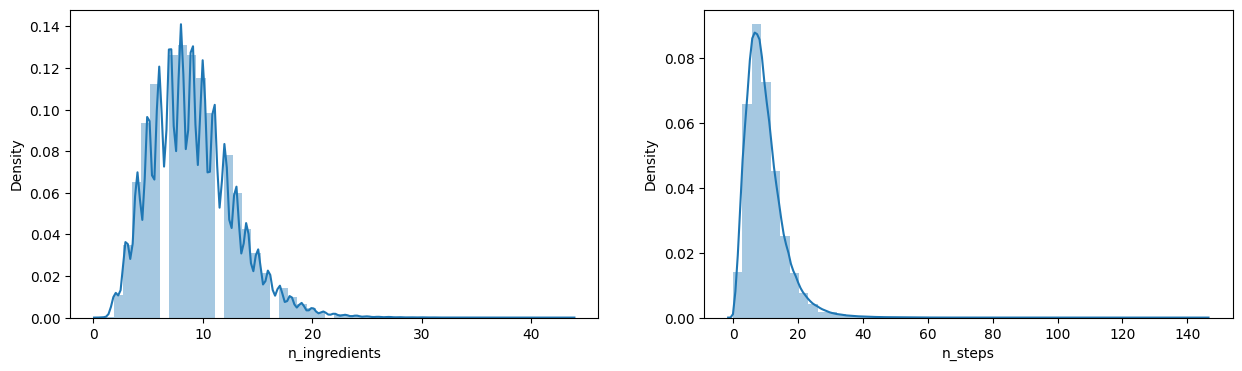

In [13]:
import seaborn

fig,ax = plt.subplots(1, 2, figsize=(15, 4))
seaborn.distplot(recipes["n_ingredients"],ax=ax[0])
seaborn.distplot(recipes["n_steps"],ax=ax[1])

<Axes: xlabel='n_ingredients', ylabel='n_steps'>

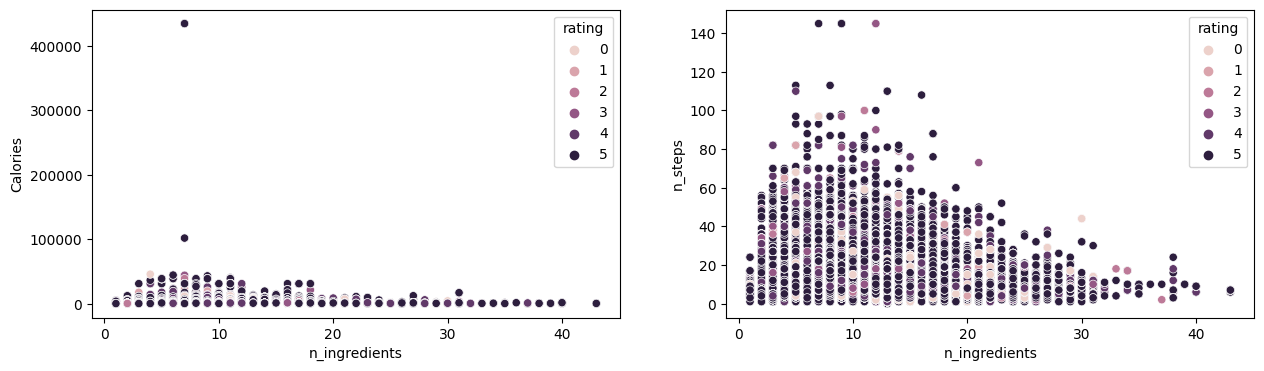

In [20]:
import seaborn as sns

fig,ax = plt.subplots(1, 2, figsize=(15,4))
sns.scatterplot(data=recipes_ratings, x="n_ingredients", y="Calories", hue="rating", ax=ax[0])
sns.scatterplot(data=recipes_ratings, x="n_ingredients", y="n_steps", hue="rating", ax=ax[1]) 